Copyright (c) 2023, University of Cambridge, all rights reserved. Written by Andrew Wheeler, University of Cambridge



# Desktop DNS Notebook 4: RANS modelling

---
### User agreement and correct use of these tools
This notebook and associated Python code are provided for non-commericial/academic use only. For those interested in commercial application of these tools please contact Andrew Wheeler (e-mail: aw329@cam.ac.uk). Please read the license agreement (LICENSE.txt).


If you use these tools for a publication please include the citation:

*Wheeler A.P.S. (2023) 'Desktop-DNS: An open toolkit for turbomachinery aerodynamics', ASME Turbo Expo 2023, ASME Paper no. GT2023-1023647*



---

## 4.0 Introduction

In this notebook we run *3DNS-gpu* in RANS mode. We prescribe an eddy viscosity using the data collected from the simulations run in Notebook 3. This allows us to determine an almost perfect turbulence model - albeit for one fixed case. However, we can then assess how accurate a Boussinesq model of turbulence is for this case. You are then free to change some of the flow conditions and re-run your simulations to determine how the eddy viscosity changes with flow conditions. The example shown in the ASME paper (cited above) is to run with different inlet angles. 

In this notebook you will:

* Create the RANS case files
* Establish an initial guess
* Set the optimum eddy viscosity
* Run the RANS simulation
* Compare DNS and RANS


In [2]:
# this cell ensures that python modules are reloaded at runtime

%reload_ext autoreload
%autoreload 2


---

## 4.1 Create the RANS case files


### Create a mesh for running in RANS mode

When running in RANS mode we no-longer need a very high resolution mesh - we wish to keep the near wall $y^+<1$, but we can relax the requirement for low aspect ratio cells and therefore reduce the refinement factor. We also run in 2D since the flow is two-dimensional.

The cells below create a suitable mesh.


In [3]:
### Create RANS mesh
from meshing.read_profile   import *

# pop-out figure
%matplotlib qt

# create refined mesh

# inilitialize dictionaries
mesh   = {}

# case name and profile coordinates
mesh['case'] = 'notebook4'
mesh['profile'] = 'geom/profile.txt'

# initial mesh inputs
mesh['npp'] = 2*[None]
mesh['ywall'] = 2*[None]
mesh['msmooths'] = 2*[None]

mesh['npp'][0] = 4
mesh['Lup'] = 1.0
mesh['Ldn'] = 1.0
mesh['Lo'] = 0.2
mesh['ywall'][0] = 0.04/150
mesh['msmooths'][0] = 500
mesh['cor_fac'] = 0.75 # factor shrinking multi-block corner cells - lower values give more shrinkage.

# final mesh inputs
mesh['npp'][1] = 28
mesh['refine_fac'] = 1.0 # use refinement factor to adjust mesh points in i-j directions 
mesh['ywall'][1] =  0.02/150 
mesh['msmooths'][1] = 200

# scale factor if used (set to 1.0 if not)
mesh['scale_factor'] = 1.0

# flip y coordinates if -1 (1 for no flip)
mesh['flip'] = 1





In [4]:
from meshing.blade_mesher import *
import timeit

start = timeit.default_timer()

# create mesh 
case = blade_mesher(mesh)

stop = timeit.default_timer()

print('Time: ', stop - start)  




Time:  105.17925589811057


Plot the mesh to check it is OK.

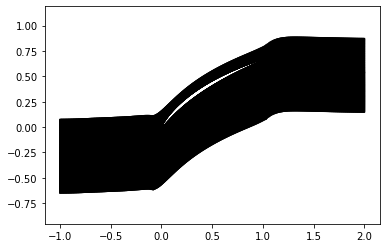

In [5]:

import matplotlib.pyplot as plt

# pop-out figures
#%matplotlib qt
%matplotlib inline


# unpack case for plotting
blk = case['blk']

# plot profile, topology and mesh
plt.figure(1)
plt.axis('equal')

for ib in range(len(blk)):
    xnew=blk[ib]['x']
    ynew=blk[ib]['y']
    plt.plot(xnew,ynew,'k')
    plt.plot(np.transpose(xnew),np.transpose(ynew),'k')

plt.show()


Now create the case files. Below the case details are copied over from Notebook 1.

In [8]:
from meshing.read_case import *
from meshing.write_case import *

# copy case details from notebook1
casename_old = 'notebook1'
casename_new = 'notebook4'

# read casefiles from old directory
case_old = read_case(casename_old)

# pack-up new case
case['casename'] = casename_new
case['bcs'] = case_old['bcs']
case['gas'] = case_old['gas']
case['solver'] = case_old['solver']

# set number of spanwise points
case['solver']['nk'] = 1 # spanwise points for 2D calculation 

# adjust number of iterations
case['solver']['niter'] = 200000

# set filter coefficient (finer meshes permit lower values)
case['solver']['sigma'] = 0.03 

# switch-off statistics
case['solver']['istats'] = 0 

# switch-off inlet perturbations
case['bcs']['aturb'] = 0.0 # amplification factor for turbulence


In [9]:

# write new casefiles
write_case(case)

Writing inputs for 3dns_gpu
Total ij points
73696
Total GPUs
1


### Create an initial inviscid guess

We follow the same steps followed in Notebook 1 and create an initial inviscid guess. This provides a starting flow for the RANS simulation.


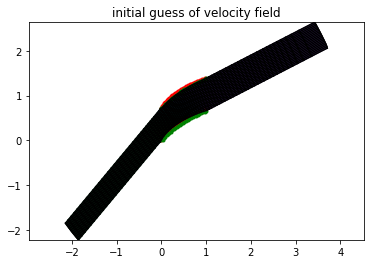

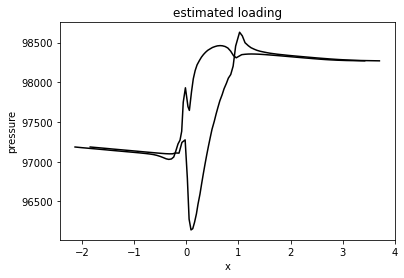

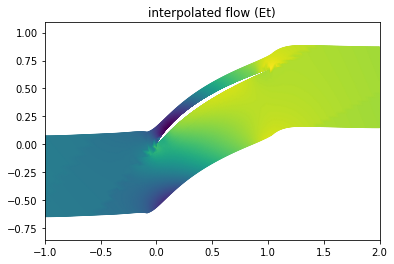

In [10]:

from meshing.initial_guess import *
from meshing.write_flo import *

casename = 'notebook4'

# create initial guess (last two integers define the streamline curvature grid dims)
# adjust total pressure with assumed loss coefficient
Yp = 0.103
prop = initial_guess(mesh,blk,case['bcs'],case['gas'],30,20,Yp)

# write initial flow files
write_flo(prop,casename)


---

## 4.2 Set the eddy viscosity 

### Determine the eddy viscosity from the previous simulations

The RANS case is nearly set-up. However we want to prescribe the eddy viscosity. In Notebook 1 we ran the case in RANS mode 1, where a simple mixing-length model was used. This time we can use the data from the high fidelity simulations to set the eddy viscosity. An optimum eddy viscosity minimizes the error in the Reynolds stress tensor (see Michelassi et al 2014*).

$\begin{equation}
\begin{aligned}
&\frac{\mu_t}{\mu} =
&\frac{\left(\begin{aligned}
 &\tau_{xy}\overline{\rho{u'v'}} + \tau_{xz}\overline{\rho{u'w'}}  + \tau_{yz}\overline{\rho{v'w'}} \\
 +&\tau_{xx}\overline{\rho{u'u'}} + \tau_{yy}\overline{\rho{v'v'}} + \tau_{zz}\overline{\rho{w'w'}} \end{aligned} \right)} {\tau_{xy}^2 + \tau_{xz}^2 + \tau_{yz}^2 + \tau_{xx}^2 +\tau_{yy}^2 + \tau_{zz}^2}
\end{aligned}
\end{equation}$


where $\tau$ is the anisotropic part of the stress tensor, determined from the traceless strain tensor. 

The read_2d_mean routine computes this automatically and returns it to the prop dictionary. The cells below are an example of how to plot this.


*V. Michelassi, L. Chen, R. Pichler, R. D. Sandberg (2014) "Compressible Direct Numerical Simulation of Low-Pressure Turbines Part {II}: Effect of Inflow Disturbances", J. Turbomachinery, vol 137, no. 7


In [11]:
# Determine eddy viscosity

from postpro.read_2d_mean import *
from postpro.plot_flo import *
from meshing.write_flo import *

casename_dns = 'notebook3/mesh3'
prop_dns,geom_dns,_=read_2d_mean(casename_dns,[6])


In [13]:
# Plot the eddy viscosity

#plot_flo(prop_dns,geom_dns,'mut_opt',[0,100])


The plot shows the viscosity ratio $\mu_t/\mu$. Notice that the the eddy viscosity is a bit noisy in the mainstream flow - this is because whereever the strain is very small, the eddy viscosity calculation becomes ill conditioned. This is a limitation of the concept of an eddy viscosity (Boussinesq hypothesis).



### Create the prescribed eddy viscosity files

The next cell creates the prescribed eddy visosity field using the write_mut routine. This interpolates the eddy viscosity onto the RANS mesh. In order to avoid the problem that the eddy visosity is ill conditioned in regions of low strain, the write_mut routine sets the eddy viscosity to zero where the strain falls below a certain threshold

$ \mu_t = \mu_t \times (1.0 - \exp(-(S/\sigma)^2) $
    
where $S$ is the strain magnitude and $\sigma= 0.0001 \times max(S)$.    




In [14]:

### Create prescribed eddy viscosity

from postpro.write_mut import *

casename = 'notebook4'

write_mut(prop_dns,geom_dns,casename)


The next cell reads in the starting solution and plots the prescribed eddy viscosity - this is shown as a ratio $\mu_t/\mu$. You'll see that this is now smoothly varying to zero in the freestream.

<module 'matplotlib.pyplot' from '/home/aw329/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

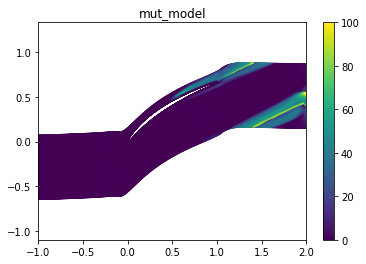

In [15]:
from postpro.read_flo import *
from postpro.plot_flo import *


# pop-out figure
#%matplotlib qt

# read flo
casename = 'notebook4'

prop,geom=read_flo(casename)

# plot flo
plot_flo(prop,geom,'mut_model',[0,100])

Now we create the 'rans.txt' file which sets up the rans input parameters.

We set if_rans=2, so that RANS mode 2 is switched on. The number of rans cases to read in is 1 in this case (nrans_file=1). The path to the rans files is the current directory. Setting nrans_file=2 allows two cases to be read in, and the value of fac is linear weighting of the eddy viscosity between the two prescribed cases. More details in the userguide.

In [16]:
from meshing.write_rans import *

casename = 'notebook4'

rans = {}

rans['if_rans'] = 2
rans['speed_up'] = 3.0
rans['nrans_file'] = 1
rans['path1'] = '"./"'
rans['path2'] = ''
rans['fac'] = 1.0


write_rans(casename,rans)


---

## 4.3 Run the RANS simulation

Now run the RANS case in the usual way. This case is set-up to run on 1 GPU - follow the same process as outlined in Notebook 1 for running this case.

Once complete, check the flow field in the usual way - the cells below read in the flow and plot Mach number

In [17]:
from postpro.read_flo import *
from postpro.plot_flo import *


# pop-out figure
%matplotlib qt

# read flo
casename = 'notebook4'

prop,geom=read_flo(casename)


<module 'matplotlib.pyplot' from '/home/aw329/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

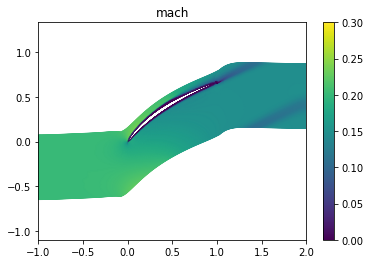

In [18]:
# plot flo
plot_flo(prop,geom,'mach',[0,0.3])
#plot_flo(prop,geom,'p',[0.96e5,1.0e5])



---

## 4.4 Compare with the DNS

99815.20533837851 97003.53933363127 99753.39159630938 98305.98346618391
DNS Yp  0.02280069764988225
RANS Yp  0.0219847385730623
Difference (%)  3.5786583785701183


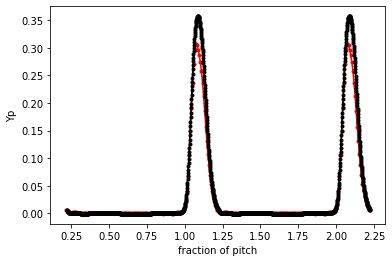

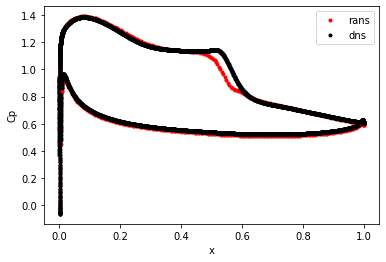

In [24]:
from postpro.yp import *

wall_blocks = [3,4,5,7]

inlet = {}
exit = {}

inlet['blocks'] = [1,2]
exit['blocks'] = [8,9]

inlet['x']= -0.5 # avoid buffer regions near inlet bc
exit['x'] = 1.25 # avoid buffer regions near exit bc

# Wake profiles

plt.figure(1)

# RANS wake
perf = yp(prop,geom,inlet,exit);
wake = perf['wake']
plt.plot(wake['y'],wake['yp'],'-r.')
# periodic repeat
plt.plot(wake['y']+1,wake['yp'],'-r.')
Yp_rans = perf['yp']
    
poin_rans = perf['poin']
pin_rans = perf['pin']

print(poin_rans,pin_rans,perf['poex'],perf['pex'])

# DNS wake
perf = yp(prop_dns,geom_dns,inlet,exit);
wake = perf['wake']
plt.plot(wake['y'],wake['yp'],'-k.')
# periodic repeat
plt.plot(wake['y']+1,wake['yp'],'-k.')
Yp_dns = perf['yp'];
#    
poin_dns = perf['poin']
pin_dns = perf['pin']

plt.xlabel('fraction of pitch')
plt.ylabel('Yp')

plt.show()

# Loading
plt.figure(2)
for i in wall_blocks:
    plt.plot(geom[i-1]['x'][:,-1],(poin_rans-prop[i-1]['p'][:,-1,0])/(poin_rans-pin_rans),'r.')
    plt.plot(geom_dns[i-1]['x'][:,-1],(poin_dns-prop_dns[i-1]['p'][:,-1])/(poin_dns-pin_dns),'k.')
plt.legend(['rans','dns'])

plt.xlabel('x')
plt.ylabel('Cp')

plt.show()

print('DNS Yp ',Yp_dns)
print('RANS Yp ',Yp_rans)
print('Difference (%) ', 100*(Yp_dns - Yp_rans)/Yp_dns)